In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# a shared drive, so add a shortcut to the folder in this account first
%cd 'drive/MyDrive/CS 275 Project - Fetch'

/content/drive/.shortcut-targets-by-id/1xWgMw0gTxniiOldOdIfCx6AIrt5y3L7O/CS 275 Project - Fetch


In [5]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import transforms, utils
from torchsummary import summary

import time
import copy

# specific package for visualization
!pip install livelossplot --quiet
from livelossplot import PlotLosses

# get the device type of machine
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Turn ONV into a numpy arr and save binary

In [6]:
# convert string of Vector3 to a numpy array
def processONV(s, r, c):
  # s    [string] holds 41*360 = 14,760 RGBA values for the ONV
  # r, c [int] rows and cols to put data into

  arr = np.zeros((r, c))

  s = s.strip()
  x = s.split(") ")

  # count zero-d out data
  count = 0

  for i, vec in enumerate(x):
    v = vec.replace("RGBA", '')
    v = v.replace("(", '')
    v = v.replace(")", '')
    v = v.split(',')

    arr[i] = np.array(v[:3])    # drop the alpha value

    """
    if r == 1:  # zero out vectors where the bone isn't in view
      # print(arr[i])
      if (abs(arr[i][0]) >= 0.16 or abs(arr[i][1]) >= 0.05):
        arr[i] = np.zeros(3)
        count += 1
      else:
        arr[i] = np.around(arr[i], decimals=3)
    """
    
  arr = np.ravel(arr)

  return arr, count

In [7]:
# todo: for labels only keep 2 decimal points
def createDataAndLabels(fileName, numReceptors, numData, data, labels):
  f = open(fileName, "r")
  count = 0

  for i in range(numData):
  
      # Get next line from file
      line = f.readline()
  
      # if line is empty
      # end of file is reached
      if not line:
          break

      c = 0

      if i % 3 == 0:   # label
        labels[i], c = processONV(line, 1, 3)
      # TODO: create one vector?
      elif i % 3 == 1: # Left ONV
        data[i][0], _ = processONV(line, numReceptors, 3)
      else:            # Right ONV
        data[i][1], _ = processONV(line, numReceptors, 3)

      count += c

  print("Num zero labels: " + str(count))

  f.close()

In [8]:
rho = 11
numReceptors = rho * 360

In [10]:
numData = 2136

data   = np.zeros((numData, 2, numReceptors * 3))
labels = np.zeros((numData, 3))

createDataAndLabels("onv.txt", numReceptors, numData, data, labels)

Num zero labels: 0


## Combine 2 Datasets

In [102]:
numData = 669

data   = np.zeros((numData, 2, numReceptors * 3))
labels = np.zeros((numData, 3))

createDataAndLabels("onv.txt", numReceptors, numData, data, labels)

Num zero labels: 0


In [103]:
# nima data
numData_2 = 1492

data_2   = np.zeros((numData_2, 2, numReceptors * 3))
labels_2 = np.zeros((numData_2, 3))

createDataAndLabels("onv-Nima.txt", numReceptors, numData_2, data_2, labels_2)

Num zero labels: 0


In [104]:
data   = np.vstack((data, data_2))
labels = np.vstack((labels, labels_2))

## Shuffle and Save/Load

In [11]:
# shuffle data
shuffler = np.random.permutation(len(labels))

data_shuffled   = data[shuffler]
labels_shuffled = labels[shuffler]

In [12]:
np.save('data_3',   data_shuffled)
np.save('labels_3', labels_shuffled)

In [46]:
data   = np.load('data_2.npy')
labels = np.load('labels_2.npy')

In [51]:
print(data.shape)
print(labels.shape)

(2161, 2, 11880)
(2161, 3)


# Dataloaders

In [15]:
class ONVDataset(Dataset):
    """EEG dataset."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):

        x, y = self.subset[index]
        if self.transform:
          pass 
            # x = self.transform(x)
            # y = self.transform(y)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [54]:
# copy numpy data to tensor
X_data_tensor = torch.from_numpy(data).float().to(device)
y_data_tensor = torch.from_numpy(labels).float().to(device)

# do not forget .long()
# y_train_valid_tensor = torch.from_numpy(y_train_valid).float().long().to(device)

In [55]:
init_dataset = TensorDataset(X_data_tensor, y_data_tensor) 

# split train, val, test
# lengths = [int(len(init_dataset)*0.6), int(len(init_dataset)*0.2), int(len(init_dataset)*0.2)+1] 
# print(lengths)
# np.save('lengths_3', np.array(lengths))
lengths = np.load('lengths_2.npy')


subset_train, subset_val, subset_test = random_split(init_dataset, lengths) 

train_data = ONVDataset(
    subset_train, transform=None)

val_data = ONVDataset(
    subset_val, transform=None)

test_data = ONVDataset(
    subset_test, transform=None)

dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True,  num_workers=0),
    'val':   torch.utils.data.DataLoader(val_data,   batch_size=16, shuffle=False, num_workers=0),
    'test':  torch.utils.data.DataLoader(test_data,  batch_size=16, shuffle=False, num_workers=0),
}


# Train Models

## Helper Funcs

In [21]:
def count_parameters(model):
  """Function for count model's parameters"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
def train_model(model, optimizer, num_epochs):
    # for each epoch... 
    liveloss = PlotLosses()

    best_model = None
    highest_val = 0

    for epoch in range(num_epochs):
      print('Training Model: ', model.__class__.__name__)
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      logs = {}

      # let every epoch go through one training cycle and one validation cycle
      # TRAINING AND THEN VALIDATION LOOP...
      for phase in ['train', 'val']:
        train_loss = 0
        correct = 0
        total = 0
        batch_idx = 0

        start_time = time.time()
        # first loop is training, second loop through is validation
        # this conditional section picks out either a train mode or validation mode
        # depending on where we are in the overall training process
        # SELECT PROPER MODE- train or val
        if phase == 'train':
          for param_group in optimizer.param_groups:
            print("LR", param_group['lr']) # print out the learning rate
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode
        
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)
          batch_idx += 1
          
          optimizer.zero_grad()
          
          with torch.set_grad_enabled(phase == 'train'):
          #    the above line says to disable gradient tracking for validation
          #    which makes sense since the model is in evluation mode and we 
          #    don't want to track gradients for validation)
            outputs = model(inputs)
            # compute loss where the loss function will be defined later

            # print(outputs.shape, labels.shape)
            print(outputs)

            loss = loss_fn(outputs, labels)
            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()
            train_loss += loss
            # _, predicted = outputs.max(1)

            total += labels.size(0)

            n_digits = 2

            # https://discuss.pytorch.org/t/round-tensor-to-x-decimal-places/25832
            labels = torch.round(labels * 10**n_digits) / (10**n_digits)
            outputs = torch.round(outputs * 10**n_digits) / (10**n_digits)

            correct += outputs.eq(labels).sum().item()

        # if phase == 'train':
        #   if  epoch%5 == 0:
        #   # prints for training and then validation (since the network will be in either train or eval mode at this point) 
        #     print(" Training Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))

        # if phase == 'val' and epoch%5 == 0:
        #   print(" Validation Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))

        prefix = ''
        if phase == 'val':
            prefix = 'val_'
            # tune.track.log(mean_accuracy=correct/total)

            if (correct/total) > highest_val:
              print('Best val till now: ', (correct/total))
              highest_val = (correct/total)
              logs['what'] = highest_val
              best_model = copy.deepcopy(model)

        logs[prefix + 'loss'] = train_loss.item()/(batch_idx)
        logs[prefix + 'acc'] = correct/total*100.

      liveloss.update(logs)
      liveloss.send()

    # end of single epoch iteration... repeat of n epochs  
    return best_model, model

In [61]:
def test_model(model):
  
  total = correct = 0

  cor = np.zeros(3)

  for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    # _, predicted = outputs.max(1)

    n_digits = 2
    labels = torch.round(labels * 10**n_digits) / (10**n_digits)
    outputs = torch.round(outputs * 10**n_digits) / (10**n_digits)

    # print(labels)
    # print(outputs)

    l = labels.cpu()
    o = outputs.cpu()

    # diffs = np.array((abs(outputs - labels) <= 0.5).cpu())
    diffs = np.array((outputs * labels >= 0).cpu())

    # print(outputs[:, 2] - labels[:, 2])
    for i in range(3):
      cor[i] += np.count_nonzero(diffs[:, i])

    for i in range(labels.shape[0]):
      if np.count_nonzero(diffs[i]) == 3:
        correct += 1
    
    bools = outputs.eq(labels)
    
    res = torch.logical_and(bools[:, 0:1], bools[:, 1:2])
    res = torch.logical_and(res, bools[:, 2:3])
    # print(res.sum().item())

    total += labels.size(0)
    # correct += outputs.eq(labels).sum().item()

  print(cor, total)
  print(correct/total)
  return correct, total

## Define Models

In [ ]:
"""
class RetinaFC(nn.Module):
    def __init__(self, in_channels):
      super(RetinaFC, self).__init__()

      self.conv1 = nn.Conv2d(in_channels, 10, (2, 4280), stride=1)
      self.conv2 = nn.Conv2d(10, 50, (1, 2000), stride=1)

      self.drop1 = nn.Dropout2d(0.2)
      self.drop2 = nn.Dropout2d(0.3)

      self.fc1 = nn.Linear(38002, 1000)
      self.fc2 = nn.Linear(1000*50, 3)

    def forward(self, x):

      x = x.view(-1, 1, 2, 44280)   # (B, 1, 2, 44280)

      x = self.conv1(x)             # (B, 10, 1, 40001)
      x = torch.relu(x)
      x = self.drop1(x)
      
      x = self.conv2(x)             # (B, 50, 1, 38002)
      x = torch.relu(x)
      x = self.drop2(x) 

      x = self.fc1(x)               # (B, 50, 1, 1000)

      x = x.reshape(-1, 50*1000)    # (B, 50000)

      x = self.fc2(x)               # (B, 3)

      # want output to be 3 numbers
      return x
"""

In [6]:
# smaller retina size, fewer params ez to train, etc.
class RetinaFC(nn.Module):
    def __init__(self, in_channels):
      super(RetinaFC, self).__init__()

      self.conv1 = nn.Conv2d(in_channels, 10, (2, 4880), stride=1)
      self.conv2 = nn.Conv2d(10, 50, (1, 2000), stride=1)

      self.drop1 = nn.Dropout2d(0.2)
      self.drop2 = nn.Dropout2d(0.3)

      self.fc1 = nn.Linear(5002, 1000)
      self.fc2 = nn.Linear(1000*50, 3)

    def forward(self, x):

      x = x.view(-1, 1, 2, 11880)   # (B, 1, 2, 11880)

      x = self.conv1(x)             # (B, 10, 1, 7001)
      x = torch.relu(x)
      x = self.drop1(x)
      
      x = self.conv2(x)             # (B, 50, 1, 5002)
      x = torch.relu(x)
      x = self.drop2(x) 

      x = self.fc1(x)               # (B, 50, 1, 1000)

      x = x.reshape(-1, 50*1000)    # (B, 50000)

      x = self.fc2(x)               # (B, 3)

      # want output to be 3 numbers
      return x

In [7]:
# smaller retina size, fewer params ez to train, etc.
class RetinaFC_2(nn.Module):
    def __init__(self, in_channels):
      super(RetinaFC_2, self).__init__()

      self.conv1 = nn.Conv2d(in_channels, 10, (2, 4880), stride=1)
      self.conv2 = nn.Conv2d(10, 50, (1, 2000), stride=1)

      self.drop1 = nn.Dropout2d(0.2)
      self.drop2 = nn.Dropout2d(0.3)

      self.fc1 = nn.Linear(5002, 1000)
      self.fc2 = nn.Linear(1000*50, 1000)
      self.fc3 = nn.Linear(1000, 3)

    def forward(self, x):

      x = x.view(-1, 1, 2, 11880)   # (B, 1, 2, 11880)

      x = self.conv1(x)             # (B, 10, 1, 7001)
      x = torch.relu(x)
      x = self.drop1(x)
      
      x = self.conv2(x)             # (B, 50, 1, 5002)
      x = torch.relu(x)
      x = self.drop2(x) 

      x = self.fc1(x)               # (B, 50, 1, 1000)
      x = torch.relu(x)

      x = x.reshape(-1, 50*1000)    # (B, 50000)

      x = self.fc2(x)               # (B, 3)
      x = torch.relu(x)

      x = self.fc3(x)

      # want output to be 3 numbers
      return x

In [35]:
# fully FC for Barracuda
class RetinaFC_3(nn.Module):
    def __init__(self, in_channels):
      super(RetinaFC_3, self).__init__()

      self.drop1 = nn.Dropout2d(0.2)
      self.drop2 = nn.Dropout2d(0.3)
      self.drop3 = nn.Dropout2d(0.3)

      self.fc1 = nn.Linear(11880, 8000)
      self.fc2 = nn.Linear(8000, 5000)
      self.fc3 = nn.Linear(5000, 1000)

      self.fc4 = nn.Linear(2000, 3)

    def forward(self, x):

      x = x.view(-1, 1, 2, 11880)   # (B, 1, 2, 11880)

      x = self.fc1(x)               # (B, 1, 2, 8000)
      x = torch.relu(x)
      x = self.drop1(x)
      
      x = self.fc2(x)               # (B, 1, 2, 5000)
      x = torch.relu(x)
      x = self.drop2(x) 
  
      x = self.fc3(x)               # (B, 1, 2, 1000)
      x = torch.relu(x)
      x = self.drop3(x) 

      x = x.reshape(-1, 2*1000)    # (B, 2000)

      x = self.fc4(x)               # (B, 3)

      # want output to be 3 numbers
      return x

## Train & Test

In [56]:
# define the hyperparameters
#weight_decay = 0.15  # weight decay to alleviate overfiting (L2 Regularization)
weight_decay = 0.1

models = {}
optimizers = {}

# models['RetinaFC'] = RetinaFC(in_channels=1).to(device)
# models['RetinaFC_2'] = RetinaFC_2(in_channels=1).to(device)
models['RetinaFC_3'] = RetinaFC_3(in_channels=1).to(device)

for model_name, model in models.items():
  count = count_parameters(model)
  print ('{} model parameters amount {}'.format(model_name, count))

  # loss_fn = nn.CrossEntropyLoss()
  loss_fn = nn.MSELoss()
  optimizers[model_name] = torch.optim.Adam(model.parameters(), lr = 1e-2, weight_decay=weight_decay)

RetinaFC_3 model parameters amount 140060003


In [37]:
summary(models['RetinaFC_3'], (1, 2, 11880))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 1, 2, 8000]      95,048,000
         Dropout2d-2           [-1, 1, 2, 8000]               0
            Linear-3           [-1, 1, 2, 5000]      40,005,000
         Dropout2d-4           [-1, 1, 2, 5000]               0
            Linear-5           [-1, 1, 2, 1000]       5,001,000
         Dropout2d-6           [-1, 1, 2, 1000]               0
            Linear-7                    [-1, 3]           6,003
Total params: 140,060,003
Trainable params: 140,060,003
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 0.43
Params size (MB): 534.29
Estimated Total Size (MB): 534.80
----------------------------------------------------------------


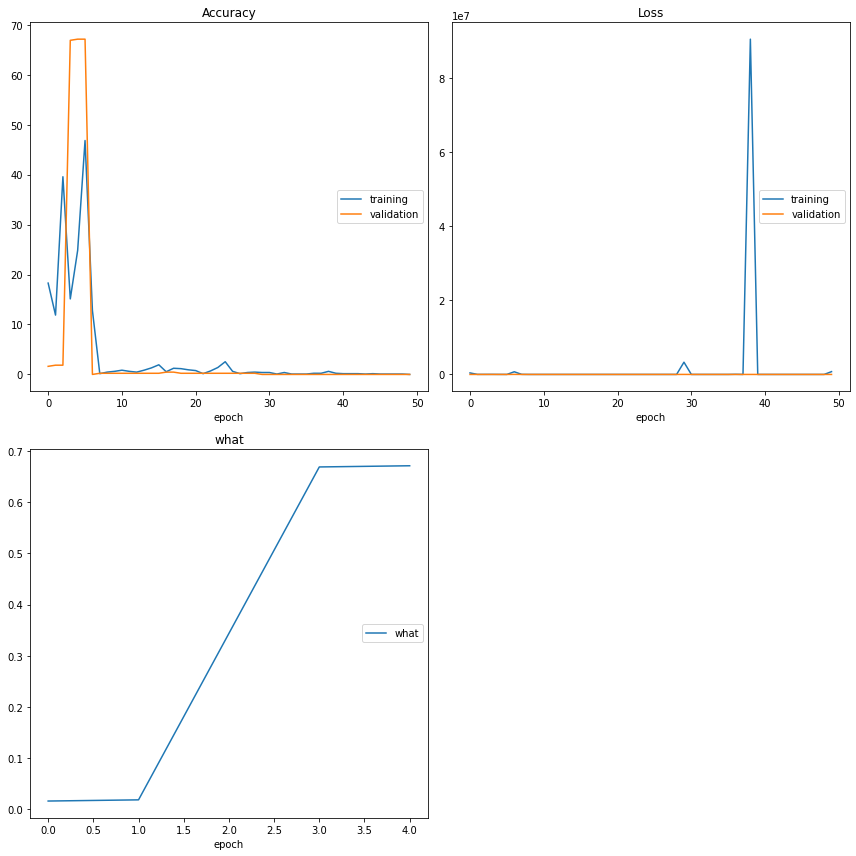

Accuracy
	training         	 (min:    0.000, max:   46.836, cur:    0.000)
	validation       	 (min:    0.000, max:   67.130, cur:    0.000)
Loss
	training         	 (min:   11.761, max: 90590588.878, cur: 753558.146)
	validation       	 (min:   11.725, max: 12050.914, cur:   12.476)
what
	what             	 (min:    0.016, max:    0.671, cur:    0.671)


In [57]:
name = 'RetinaFC_3'
best_model, models[name]=train_model(models[name], optimizers[name], num_epochs=50)

In [45]:
# difference
for model_name, model in models.items():
  model.eval()
  correct, total = test_model(model)

[  0. 418. 288.] 428
0.0


In [40]:
# direction
for model_name, model in models.items():
  model.eval()
  correct, total = test_model(model)

[344. 415. 288.] 428
0.0


In [58]:
# Same DataSet as CONV
# difference
for model_name, model in models.items():
  model.eval()
  correct, total = test_model(model)

[348.   0. 297.] 433
0.0


In [62]:
# direction
for model_name, model in models.items():
  model.eval()
  correct, total = test_model(model)

[358. 363. 433.] 433
0.7367205542725174


In [41]:
 torch.save(models['RetinaFC_3'], 'retinaFC_full')

# Analyze


In [18]:
m = torch.load('./retinaFC_3layers_lotsOfData_2')

In [115]:
m = models['RetinaFC_2']

In [157]:
# distance
m.eval()
correct, total = test_model(m)

[62. 10.  6.] 433
0.0023094688221709007


In [165]:
# direction
m.eval()
correct, total = test_model(m)

[70.  7. 11.] 433
0.0023094688221709007


In [137]:
m2 = torch.load('./retinaFC_3layers_lotsOfData')

In [16]:
data    = np.load('data.npy')
labels  = np.load('labels.npy')
lengths = np.load('lengths.npy')

In [155]:
# distance
m2.eval()
correct, total = test_model(m2)

[14.  0.  0.] 433
0.0


In [162]:
# direction
m2.eval()
correct, total = test_model(m2)

[25.  0.  0.] 433
0.0


In [60]:
count = 0
for l in labels:
  if l[0] == 0 and l[1] == 0 and l[2] == 0:
    count += 1

print(count, labels.shape[0])

617 669


In [19]:
total = count = 0

nonZeroTest = []

for inputs, labl in dataloaders['test']:

    for l in labl:
      if l[0] == 0 and l[1] == 0 and l[2] == 0:
        count += 1
      else:
        nonZeroTest.append(l)

      total += 1

print(count, total)

425 433


# Create ONYX Model

In [44]:
# Export the model to Onyx

x = torch.randn(1, 2, 11880)

torch.onnx.export(models['RetinaFC_3'],                       # model being run
                  x.cuda(),                         # model input (or a tuple for multiple inputs)
                  "retina2.onnx",            # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=9,           # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['X'],       # the model's input names
                  output_names = ['Y']       # the model's output names
                  )